In [1]:
%%shell
pip install cython 
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9pdbt006
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9pdbt006
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263923 sha256=768cfdca2b907361d4f7746a9e295d5e83bcc738740b4c7f4eeb6140e4d3ffba
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehayw4ex/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [2]:
# Library imports
from PIL import Image
import time, math, cv2, imutils, os, json, random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
TRAIN_DIR = Path.cwd().parent.joinpath('content/drive/MyDrive/benchmark_velocity_train/clips')

#TEST_DIR = Path.cwd().parent.joinpath('content/test_set')

In [4]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all labels
        self.clip_nums = [x for x in os.listdir(self.root) if 'DS_Store' not in x]
        self.img_paths = [Path(root).joinpath(num).joinpath('imgs').joinpath('040.jpg') for num in self.clip_nums]
        self.anno = [Path(root).joinpath(x).joinpath('annotation.json') for x in self.clip_nums]

    def __getitem__(self, idx):
        # load images and masks
        anno_pth = self.anno[idx]
        with open(anno_pth) as f:
          anno_data = json.load(f)
        
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        mask = np.zeros(np.array(img).shape[0:2])
        boxes = []

        for car in anno_data:
            print()
            left = int(car['bbox']['left'])
            right = int(car['bbox']['right'])
            top = int(car['bbox']['top'])
            bottom = int(car['bbox']['bottom'])
            start_point = (left, top)
            end_point = (right, bottom)  
            color =  1
            thickness = -1
            # Add bounding box
            mask = cv2.rectangle(mask, start_point, end_point, color, thickness) 

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

In [5]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../ &> /dev/null
cp references/detection/transforms.py ../ &> /dev/null
cp references/detection/coco_eval.py ../ &> /dev/null
cp references/detection/engine.py ../ &> /dev/null
cp references/detection/coco_utils.py ../ &> /dev/null

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
dataset_train = CarDataset(TRAIN_DIR, get_transform(train=True))


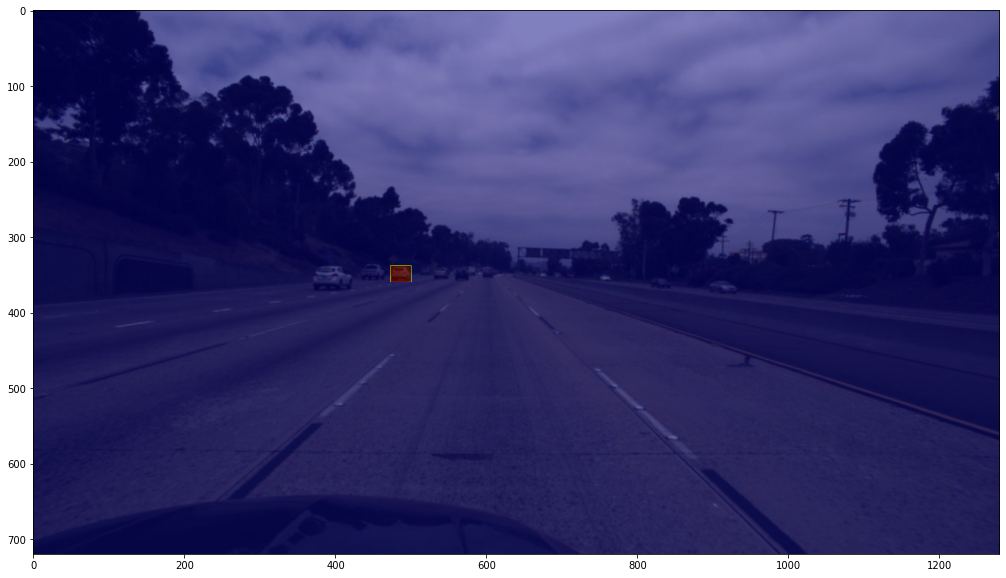

In [9]:
img, tar = dataset_train[4]
mask = tar['masks'][0]
image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.show()

In [10]:
# use our dataset and defined transformations
dataset_train = CarDataset(TRAIN_DIR, get_transform(train=True))
dataset_valid = CarDataset(TRAIN_DIR, get_transform(train=False))

# split the dataset in train and validation sets
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()
TRAIN_SIZE = int(0.8*len(indices))
dataset_train = torch.utils.data.Subset(dataset_train, indices[:TRAIN_SIZE])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[TRAIN_SIZE:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
   dataset_valid, batch_size=1, shuffle=False, num_workers=4,
   collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and car
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.


















































































































Epoch: [1]  [350/430]  eta: 0:00:51  lr: 0.005000  loss: 0.1957 (0.2510)  loss_classifier: 0.0434 (0.0520)  loss_box_reg: 0.0417 (0.0469)  loss_mask: 0.1026 (0.1442)  loss_objectness: 0.0007 (0.0047)  loss_rpn_box_reg: 0.0008 (0.0032)  time: 0.6421  data: 0.0106  max mem: 2779



































































































































Epoch: [1]  [400/430]  eta: 0:00:19  lr: 0.005000  loss: 0.2200 (0.2481)  loss_classifier: 0.0442 (0.0515)  loss_box_reg: 0.0411 (0.0463)  loss_mask: 0.1227 (0.1425)  loss_objectness: 0.0018 (0.0046)  loss_rpn_box_reg: 0.0010 (0.0032)  time: 0.6366  data: 0.0106  max mem: 2779





















































Epoch: [1]  [429/430]  eta: 0:00:00  lr: 0.005000  loss: 0.2076 (0.2461)  loss_classifier: 0.04

# Inference

In [13]:
#model = torch.load('drive/MyDrive/carDetectionModel.pkl')

In [14]:
TEST_DIR = Path.cwd().parent.joinpath('content/drive/MyDrive/benchmark_velocity_test/clips')
dataset_test = CarDataset(TEST_DIR, get_transform(train=False))

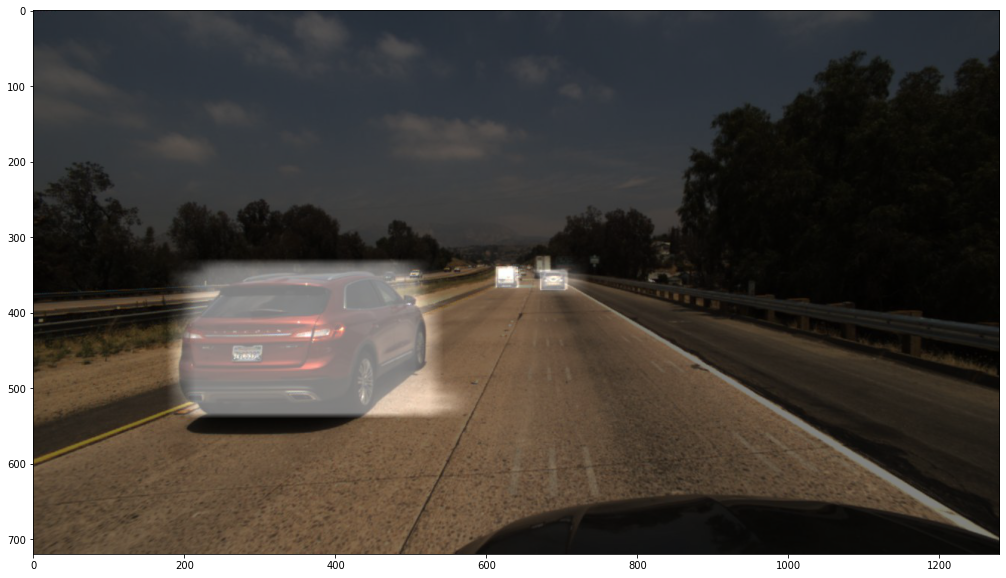

In [15]:
idx = 50
# pick one image from the test set
img, _ = dataset_test[idx]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

plt.figure(figsize=(20,10))
plt.imshow(image)
mask = np.zeros(img.shape[1:])

for n in range(len(prediction[0]['masks'])):
  mask += prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy()


mask = Image.fromarray(mask)
plt.imshow(mask, cmap='jet', alpha=0.50)
plt.show()

In [16]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
count_parameters(model)

43699995

In [18]:
torch.save(model, 'drive/MyDrive/carDetectionModel.pkl')

In [ ]:
while True:pass